# 01c — Labels from MRDS (positives per grid cell)

This notebook converts **MRDS** point records into **binary labels per grid cell**:
- `y=1` if any MRDS point intersects the grid cell  
- `y=0` otherwise

Options:
- Filter to **critical commodities** (Cu, Ni, Co, Li, etc.)
- Save final labels to `data/processed/y_labels.npy`


In [1]:
# 1) Imports & params
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import joblib
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path
import sys

# Make 'src/' importable (assumes this notebook lives in notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.data_utils import bounding_box_for_state, state_polygon
from src.features import build_grid_from_bbox, grid_centroids

# ---- Config ----

STATE = "Missouri"                        # or "MO" depending on data_utils
MRDS_CSV = project_root / "data/raw/mrds.csv"            # your MRDS CSV with the headers you shared
FILTER_CRITICAL = True                    # False to use all MRDS
# Deduplicated critical commodity codes (upper-case)
CRITICAL_COMMODITIES = {"CU","NI","CO","LI"}
GRID_PATH = project_root / "data/processed/grid_gdf.joblib"  # preferred if you already built the grid
SAVE_LABELS_PATH = project_root / "data/processed/y_labels.npy"
SAVE_FIGURES_PATH = project_root / "figures"

os.makedirs(GRID_PATH.parent, exist_ok=True)
os.makedirs(SAVE_LABELS_PATH.parent, exist_ok=True)
os.makedirs(SAVE_FIGURES_PATH, exist_ok=True)


In [2]:
## 2) Load / build grid (polygon-masked)

poly = state_polygon(STATE)  # uses data/raw/state_geology.gpkg if available; else falls back to bbox
if hasattr(poly, "geom_type"):
    # shapely Polygon/MultiPolygon; ensure CRS later matches 4326
    pass

if os.path.exists(GRID_PATH):
    grid = joblib.load(GRID_PATH)
    print(f"Loaded grid from {GRID_PATH} with {len(grid)} cells")

    # Ensure the loaded grid is masked to the polygon (older cache may be bbox-only)
    n_before = len(grid)
    grid = grid[grid.geometry.intersects(poly)].copy().reset_index(drop=True)
    if len(grid) != n_before:
        print(f"Masked cached grid to state polygon: {n_before} -> {len(grid)} cells")
        joblib.dump(grid, GRID_PATH)  # overwrite cached grid with masked version
else:
    print(f"Grid not found at {GRID_PATH}; building from state polygon for {STATE}")
    # Build on polygon bbox (fast), then mask to polygon (accurate)
    bbox = poly.bounds  # (minx, miny, maxx, maxy)
    grid = build_grid_from_bbox(bbox)
    grid = grid[grid.geometry.intersects(poly)].copy().reset_index(drop=True)
    joblib.dump(grid, GRID_PATH)
    print(f"Built and saved polygon-masked grid to {GRID_PATH} with {len(grid)} cells")

# Ensure lat/lon CRS for joins
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)


Loaded grid from c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\grid_gdf.joblib with 7646 cells


In [3]:
## 3) Load MRDS & create mineral-specific labels

mrds = pd.read_csv(MRDS_CSV)
print("MRDS rows (raw):", len(mrds))

# Drop missing coords & ensure sane values
mrds = mrds.dropna(subset=["longitude", "latitude"])
mrds = mrds[(mrds["longitude"].between(-180, 180)) & (mrds["latitude"].between(-90, 90))]
print(f"MRDS rows (with valid coords): {len(mrds)}")

# Helper: detect if any critical commodity occurs in a row
commodity_cols = [c for c in ["commod1","commod2","commod3"] if c in mrds.columns]

def row_has_any(row, targets):
    for c in commodity_cols:
        val = str(row.get(c, "")).upper()
        for t in targets:
            if t in val:
                return True
    return False

if FILTER_CRITICAL:
    mrds = mrds[mrds.apply(lambda r: row_has_any(r, CRITICAL_COMMODITIES), axis=1)].copy()
    print(f"MRDS rows after critical filter ({len(CRITICAL_COMMODITIES)} commodities): {len(mrds)}")
else:
    print("Critical filtering disabled; using all MRDS records.")

# Create GeoDataFrame from MRDS points
mrds_gdf = gpd.GeoDataFrame(
    mrds, 
    geometry=gpd.points_from_xy(mrds.longitude, mrds.latitude), 
    crs="EPSG:4326"
)

# Clip to state polygon for efficiency
mrds_in_state = gpd.clip(mrds_gdf, poly)
print(f"MRDS points inside state polygon: {len(mrds_in_state)}")

# Save filtered occurrence points for provenance (optional)
crit_points_path = project_root / "data/processed/mrds_critical_points.gpkg"
try:
    mrds_in_state.to_file(crit_points_path, driver="GPKG")
    print(f"Saved filtered critical points to {crit_points_path.name}")
except Exception as e:
    print(f"[warn] Could not save critical points GPKG: {e}")

# --- Generate and save labels for each mineral ---
all_minerals = ["cu", "ni", "co", "li"]
summary_stats = []

for mineral in all_minerals:
    # Find MRDS records for the current mineral
    def row_has_mineral(row):
        vals = [str(row.get(c, "")).upper() for c in commodity_cols]
        return any(mineral.upper() in v for v in vals)

    mineral_sites = mrds_in_state[mrds_in_state.apply(row_has_mineral, axis=1)]
    
    if mineral_sites.empty:
        print(f"\nNo MRDS sites found for '{mineral.upper()}'. Saving all-zero labels.")
        y_labels = np.zeros(len(grid), dtype=int)
    else:
        positive_cells = gpd.sjoin(grid, mineral_sites, how="inner", predicate="intersects")
        positive_indices = positive_cells.index.unique()
        y_labels = np.zeros(len(grid), dtype=int)
        y_labels[positive_indices] = 1

    output_path = SAVE_LABELS_PATH.parent / f"y_labels_{mineral}.npy"
    np.save(output_path, y_labels)
    
    n_pos = y_labels.sum()
    pos_rate = n_pos / len(grid) if len(grid) > 0 else 0
    summary_stats.append({
        "mineral": mineral,
        "n_sites": len(mineral_sites),
        "n_positive_cells": n_pos,
        "positive_rate": pos_rate
    })
    print(f"\n--- {mineral.upper()} ---")
    print(f"Found {len(mineral_sites)} sites.")
    print(f"Positive cells: {n_pos} of {len(grid)} ({pos_rate:.4f})")
    print(f"Saved labels to: {output_path.name}")

# --- Display Summary ---
summary_df = pd.DataFrame(summary_stats)
print("\n--- Label Generation Summary ---")
print(summary_df.to_string())


C:\Users\angel\AppData\Local\Temp\ipykernel_41560\2439841130.py:3: DtypeWarning: Columns (3,17,25,26,28,34,35,37,39,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  mrds = pd.read_csv(MRDS_CSV)


MRDS rows (raw): 304632
MRDS rows (with valid coords): 304613
MRDS rows (with valid coords): 304613
MRDS points inside state polygon: 12895

No MRDS sites found for 'CU'. Saving all-zero labels.

--- CU ---
Found 0 sites.
Positive cells: 0 of 7646 (0.0000)
Saved labels to: y_labels_cu.npy
MRDS points inside state polygon: 12895

No MRDS sites found for 'CU'. Saving all-zero labels.

--- CU ---
Found 0 sites.
Positive cells: 0 of 7646 (0.0000)
Saved labels to: y_labels_cu.npy

--- NI ---
Found 70 sites.
Positive cells: 42 of 7646 (0.0055)
Saved labels to: y_labels_ni.npy

--- CO ---
Found 1002 sites.
Positive cells: 621 of 7646 (0.0812)
Saved labels to: y_labels_co.npy

--- NI ---
Found 70 sites.
Positive cells: 42 of 7646 (0.0055)
Saved labels to: y_labels_ni.npy

--- CO ---
Found 1002 sites.
Positive cells: 621 of 7646 (0.0812)
Saved labels to: y_labels_co.npy

--- LI ---
Found 70 sites.
Positive cells: 50 of 7646 (0.0065)
Saved labels to: y_labels_li.npy

--- Label Generation Summary

In [4]:
## 4) Create GeoDataFrame & spatial join to grid
# Create points GDF
occ = gpd.GeoDataFrame(
    mrds,
    geometry=gpd.points_from_xy(mrds["longitude"], mrds["latitude"]),
    crs="EPSG:4326",
)
occ = occ[occ.within(poly)].copy()
print("MRDS points inside state polygon:", len(occ))


# Spatial join — reset grid index so we can group back reliably
# NOTE: Requires rtree or pygeos installed for speed (conda-forge: rtree)
joined = gpd.sjoin(grid.reset_index(), occ[["geometry"]], how="left", predicate="intersects")

# Aggregate back to 1 row per grid cell:
# y=1 if any match exists for that cell; else 0
y_series = joined.groupby("index")["index_right"].apply(lambda x: int(x.notna().any()))

# Align with original grid index/order
grid = grid.copy()
grid["y_label"] = y_series.reindex(grid.index, fill_value=0).astype(int)

# Save labels
y = grid["y_label"].values.astype(np.int64)
np.save(SAVE_LABELS_PATH, y)
print(f"Saved labels to {SAVE_LABELS_PATH}")
print("Positive cells:", int(y.sum()), "of", len(y), "| Pos rate:", float(y.mean()))

MRDS points inside state polygon: 12895
Saved labels to c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\y_labels.npy
Positive cells: 3162 of 7646 | Pos rate: 0.4135495684017787
Saved labels to c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\y_labels.npy
Positive cells: 3162 of 7646 | Pos rate: 0.4135495684017787


In [ ]:
# 4b) Aggregate per-mineral labels into a unified critical label (union)
try:
    per_arrays = []
    for m in ["cu","ni","co","li"]:
        p = project_root / f"data/processed/y_labels_{m}.npy"
        if p.exists():
            per_arrays.append(np.load(p))
    if per_arrays:
        crit_union = np.clip(np.sum(per_arrays, axis=0), 0, 1)
        np.save(project_root / "data/processed/y_labels_crit.npy", crit_union.astype(np.int8))
        print("Saved unified critical label array y_labels_crit.npy (union of Cu/Ni/Co/Li).")
except Exception as e:
    print(f"[warn] Could not build unified critical labels: {e}")


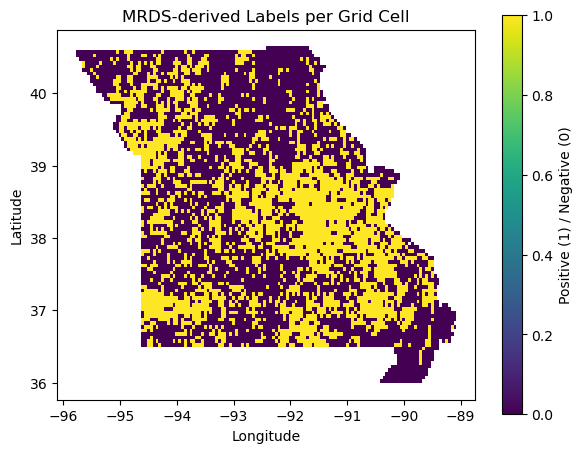

,n_cells,n_pos,pos_rate,filter_critical,critical_set
0,7646,3162,0.41355,True,"CO,CU,LI,NI"


Saved c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\labels_summary.png and c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\labels_summary.csv


In [5]:
## 5) Quick visualization & summary
# 5a) Map (quick sanity)
fig, ax = plt.subplots(figsize=(6,6))
grid.assign(pos=grid["y_label"]).plot(
    column="pos", ax=ax, cmap="viridis", legend=True,
    legend_kwds={"label": "Positive (1) / Negative (0)", "shrink": 0.7},
)
ax.set_title("MRDS-derived Labels per Grid Cell (Critical Filter Applied)" if FILTER_CRITICAL else "MRDS-derived Labels per Grid Cell (All Commodities)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig(SAVE_FIGURES_PATH / "labels_summary.png", dpi=180)
plt.show()

# 5b) Small table summary
summary = pd.DataFrame({
    "n_cells": [len(grid)],
    "n_pos": [int(y.sum())],
    "pos_rate": [float(y.mean())],
    "filter_critical": [FILTER_CRITICAL],
    "critical_set": [",".join(sorted(CRITICAL_COMMODITIES)) if FILTER_CRITICAL else ""],
})
display(summary)
summary.to_csv(SAVE_FIGURES_PATH / "labels_summary.csv", index=False)
print(f"Saved {SAVE_FIGURES_PATH / 'labels_summary.png'} and {SAVE_FIGURES_PATH / 'labels_summary.csv'}")

np.save(project_root / "data/processed/y_labels_crit.npy", y)
with open(project_root / "data/processed/labels_meta.txt","w") as f:
    f.write(f"source=MRDS\nfilter_critical={FILTER_CRITICAL}\ncommodities={','.join(sorted(CRITICAL_COMMODITIES)) if FILTER_CRITICAL else 'ALL'}\n")


# 02a – Labels from MRDS (aligned to grid)

This notebook generates binary labels by checking for the presence of critical mineral deposits from the USGS MRDS database within each cell of the authoritative grid.

**Crucially, it loads the master `grid_gdf.joblib` file to ensure the output `y_labels_crit.npy` has the exact same number of rows as the feature matrices.** This resolves the common `ValueError: Found input variables with inconsistent numbers of samples`.

**Outputs:**
- `data/processed/y_labels_crit.npy` (binary labels for Cu, Ni, Co, Li)
- `data/processed/y_labels_<mineral>.npy` (optional, per-mineral labels)
- `data/processed/targets_crit.gpkg` (optional, deposit points used for labeling)
